# If you pluck a graph, how does it twang?

_(An attempt to understand the dreaded **eigenvalues of the graph Laplacian**, written by Douglas Orr & Andrew Fitzgibbon)_

This notebook largely based on [Wikipedia: Laplacian matrix](https://en.wikipedia.org/wiki/Laplacian_matrix) & trying to build some sort of intuition myself. I'm sure there are many better resources out there.

In [ ]:
import urllib.request
import numpy as np
import scipy.signal
import scipy.linalg
import scipy.ndimage
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx

# Edgy beginnings

To understand the graph Laplacian, let's start with a simple regular graph: a 2D grid of pixels.
We can define a 2D convolutional filter over such an image that looks like this:

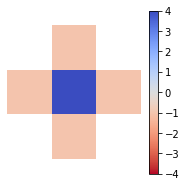

In [ ]:
laplace_filter = np.array(
    [[0, -1, 0],
     [-1, 4, -1],
     [0, -1, 0]]
)

plt.figure(figsize=(3, 3))
plt.imshow(np.where(laplace_filter == 0, np.nan, laplace_filter), cmap="coolwarm_r", vmin=-4)
plt.axis("off")
plt.colorbar();

The center pixel gets a positive weight +4, but all neighbours {N,S,E,W} get a negative weight -1.

So, pixels that are different from their neighbours will be bright and pixels that are similar to neighbours will be dark. This sounds like it will detect edges - so we'll call it an _edge detector_. Let's see what it does to Pierre-Simon Laplace himself.

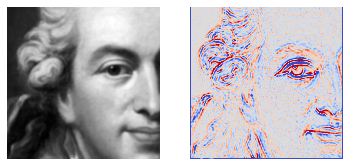

In [ ]:

# Load
url = "https://upload.wikimedia.org/wikipedia/commons/a/ac/Pierre-Simon_de_Laplace_by_Johann_Ernst_Heinsius_%281775%29.jpg"
urllib.request.urlretrieve(url, "image.jpg")
image = matplotlib.image.imread("image.jpg")
# Grayscale
image = np.mean(image, axis=-1)
# Blur
image = scipy.ndimage.gaussian_filter(image, sigma=1)
# Crop
image = image[140:340, 130:330]

_, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(image, cmap="gray")
ax1.imshow(scipy.signal.convolve2d(image, laplace_filter, mode="same"),
           cmap="coolwarm_r", vmin=-16, vmax=16)
ax0.axis("off"); ax1.axis("off");

# Eigen a figure this out

Now let's try to understand the _eigenvectors_ of this thing...
An eigenvector is a vector that stays the same (up to an overall scale factor) after applying the matrix/operator.

So, what images would remain the same after applying the Laplace filter (edge detector)?

Perhaps the most obvious case is alternating pixels. In this case all neighbours will have opposite sign, so will add up constructively.

Let's check. _(Note some edge effects due to missing off-boundary edges, so `show_filtered` trims a 1-pixel boundary .)_

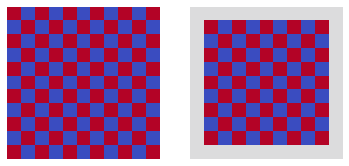

In [ ]:
def show_filtered(image):
    _, (ax0, ax1) = plt.subplots(1, 2)
    ax0.imshow(image, cmap="coolwarm_r", vmin=-1, vmax=1)
    filtered = scipy.signal.convolve2d(image, laplace_filter, mode="valid")
    filtered = np.pad(filtered, 1, constant_values=0)
    ax1.imshow(filtered, cmap="coolwarm_r", vmin=-8, vmax=8)
    ax0.axis("off"); ax1.axis("off");

size = 11
image = (2 * (np.arange(size * size) % 2) - 1).reshape(size, size)
show_filtered(image)

We can also simply make a wider version of this same pattern. It won't constructively add up as perfectly as the 1-pixel case, but the pattern still remains the same under the Laplace filter:

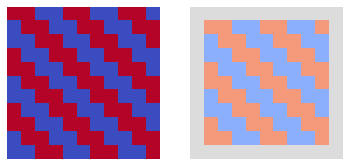

In [ ]:
image = (2 * ((np.arange(size * size) // 2) % 2) - 1).reshape(size, size)
show_filtered(image)

Finally, consider the extreme of a flat-value input image (all ones). Then the Laplace filter will combine pixels destructively:

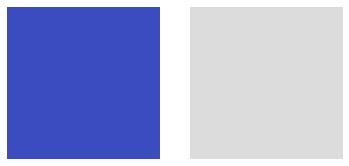

In [ ]:
image = np.ones((size, size))
show_filtered(image)

So these three images are (nearly) eigenvectors of the Laplace filter kernel. When you convolve the Laplace filter over one of these images, it stays the same, except for scaling.

# Get graphical

We started looking at images, edge detectors & convolutions with the promise that we could take our knowledge over to graphs.

Consider what our image example would look like as a graph. We connect each pixel to its {N,S,E,W} neighbours to get an adjacency matrix.

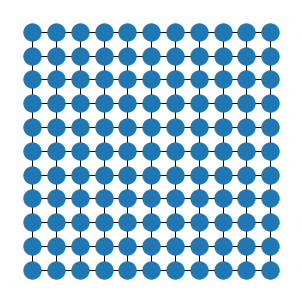

In [ ]:
size = 11

adjacency = np.array([
    [(int(abs(a // size - b // size)), int(abs(a % size - b % size))) in {(0, 1), (1, 0)}
     for a in np.arange(size * size)]
    for b in np.arange(size * size)
])

plt.figure(figsize=(4, 4))
nx.draw(nx.from_numpy_array(adjacency), {i: [i % size, i // size] for i in range(size * size)});

Now we can finally construct the graph Laplacian we've been waiting for. We won't do any normalisation, so it's just node degree along the diagonal, minus the adjacency matrix. In fewer words,

$$L = \mathrm{diag}(\sum_j A_{*,j}) - A \;,$$

where $A$ is the symmetric adjacency matrix of an undirected graph.

We had generated a few intuitive guesses previously, but now let's look at the actual eigenvectors of $L$ (this time, with edge effects).

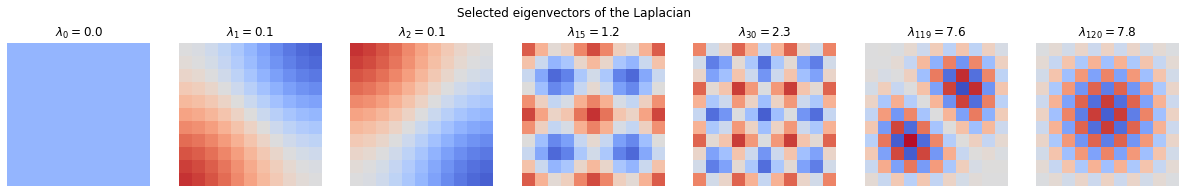

In [ ]:
laplacian = np.diag(adjacency.sum(-1)) - adjacency

eigenvalues, eigenvectors = np.linalg.eigh(laplacian)

indices = [0, 1, 2, 15, 30, size*size - 2, size*size - 1]
for idx, ax in zip(indices, plt.subplots(1, len(indices), figsize=(3 * len(indices), 3))[1]):
    ax.imshow(eigenvectors[:, idx].reshape(size, size), cmap="coolwarm_r", vmin=-0.2, vmax=0.2)
    ax.set_title(f"$\\lambda_{{{idx}}} = {eigenvalues[idx]:.1f}$")
    ax.axis("off")
plt.suptitle("Selected eigenvectors of the Laplacian", y=1);

Let's recap what we've seen:
 - The Laplacian is **like an edge detector** acting on an image.
 - Laplacian eigenvectors represent different frequency bases.
   - **Small eigenvalues for low frequency bases.**
   - **Large eigenvalues for high frequency bases.**
 - We note that these frequency bases are quite like the absolute positional embeddings you might find in a sequence or grid Transformer.

# Going off-grid

So far we've seen regular grids, but how does this apply in the broader world of irregular graphs?

First, note that the Laplacian always contains one or more zero eigenvalues, for example the all-ones eigenvector. It makes sense, then, that **if our graph contains multiple connected components, they will each have their own zero eigenvector**. Let's check:

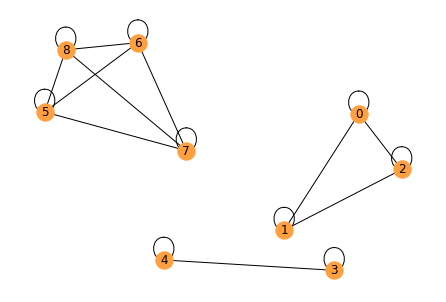

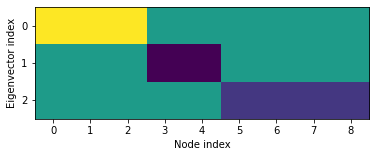

In [ ]:
adjacency = scipy.linalg.block_diag(np.ones((3, 3)), np.ones((2, 2)), np.ones((4, 4)))

g = nx.from_numpy_array(adjacency)
nx.draw(g, pos=nx.spring_layout(g, k=1.5, seed=30), with_labels=True, node_color="#ffa040")

laplacian = np.diag(adjacency.sum(-1)) - adjacency
eigenvalues, eigenvectors = np.linalg.eigh(laplacian)

plt.figure()
plt.imshow(eigenvectors[:, :3].T)
plt.ylabel("Eigenvector index")
plt.xlabel("Node index");

# If you pluck a graph, how does it twang?

Drawing it all together, there's some sense that the **eigenvectors of the Laplacian are like resonating modes of the graph** - stable frequency components. Small eigenvalues ($\lambda$) for low frequency bases. The lowest possible frequency is zero, so we get a $\lambda\!=\!0$ eigenvector for each connected component.

Often, graphs aren't quite so extreme as to have completely disconnected components. Instead, we can imagine that **small eigenvalue (low frequency) components will implicitly cluster the graph into weakly connected parts**, as eigenvectors that vary across strongly connected regions will correspond to large eigenvalues (high frequency).

Hopefully this is somewhat visible in the example of a non-uniform graph below.

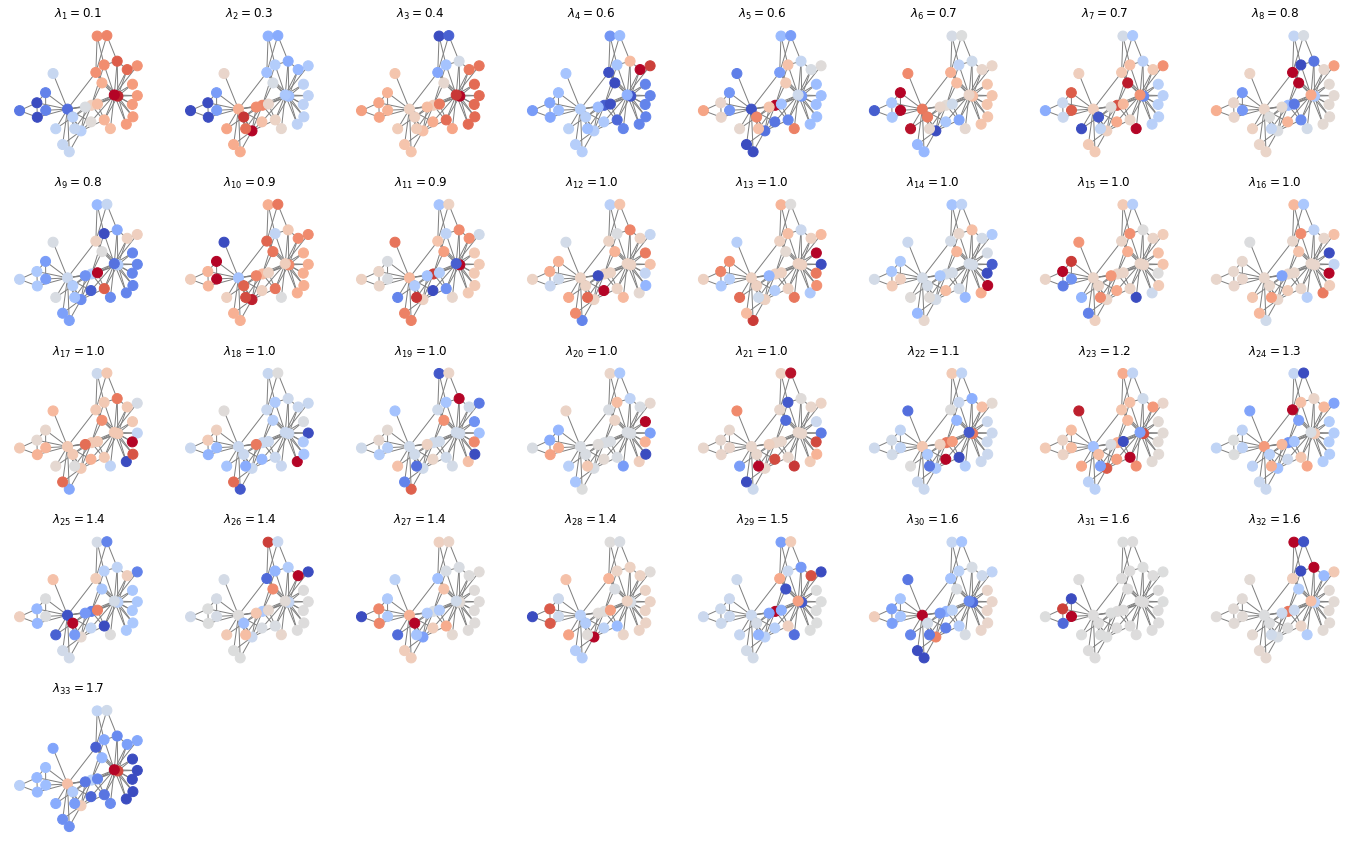

In [ ]:
g = nx.karate_club_graph()
# g = nx.davis_southern_women_graph()
# g = nx.random_internet_as_graph(20)
# g = nx.to_undirected(nx.navigable_small_world_graph(5))
# g = nx.connected_caveman_graph(5, 4)
# g = nx.florentine_families_graph()

pos = nx.spring_layout(g, seed=123)

laplacian = nx.normalized_laplacian_matrix(g).todense()
eigenvalues, eigenvectors = np.linalg.eigh(laplacian)

indices = list(range(1, eigenvectors.shape[-1]))
ncols = 8
nrows = int(np.ceil(len(indices) / ncols))
axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows))[1].flatten()
for ax in axs:
    ax.axis("off")
for idx, ax in zip(indices, axs):
    v = np.array(eigenvectors)[:, idx]
    norm = matplotlib.colors.Normalize(np.min(v), np.max(v))
    nx.draw(g, node_color=[matplotlib.cm.coolwarm_r(norm(x)) for x in v],
            ax=ax, node_size=100, edge_color="gray", pos=pos)
    ax.set_title(f"$\\lambda_{{{idx}}} = {eigenvalues[idx]:.1f}$")

_...and that's all. Thanks for listening!_

# Appendix

Trying a circular-border and square torus-looped meshes to simplify/remove edge effects.

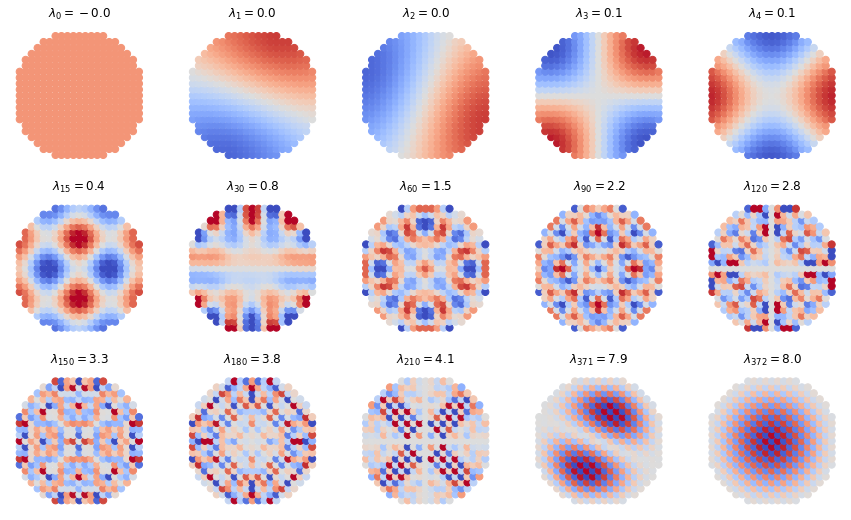

In [ ]:
size = 22
idx = np.arange(size * size)
x = idx % size
y = idx // size
mask = ((2 * x / size - 1) ** 2 + (2 * y / size - 1) ** 2) < 1
x = x[mask]
y = y[mask]
adjacency = ~np.eye(len(x), dtype=np.bool_) & ((x - x[:, np.newaxis]) ** 2 + (y - y[:, np.newaxis]) ** 2 < 1.9)

laplacian = np.diag(adjacency.sum(-1)) - adjacency
eigenvalues, eigenvectors = np.linalg.eigh(laplacian)

g = nx.from_numpy_array(adjacency)
pos = {i: [float(x[i]), float(y[i])] for i in range(len(x))}

idxs = [0, 1, 2, 3, 4, 15, 30, 60, 90, 120, 150, 180, 210,
        adjacency.shape[0]-2, adjacency.shape[0]-1]
ncols = 5
nrows = int(np.ceil(len(idxs) / ncols))
_, axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows))
for ax in axs.flatten():
    ax.axis("off")
for idx, ax in zip(idxs, axs.flatten()):
    v = eigenvectors[:, idx]
    norm = matplotlib.colors.Normalize(-0.1, 0.1)
    nx.draw(g, pos={i: [float(x[i]), float(y[i])] for i in range(len(x))},
            node_color=[matplotlib.cm.coolwarm_r(norm(x)) for x in v],
            node_size=50,
            ax=ax)
    ax.set_title(f"$\lambda_{{{idx}}}={eigenvalues[idx]:.1f}$")

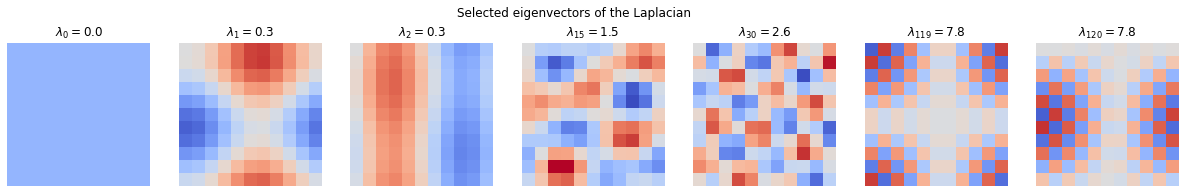

In [ ]:
# A torus-looped mesh, to ablate boundary effects...

size = 11

adjacency = nx.to_numpy_array(nx.grid_graph((size, size), periodic=True))
laplacian = np.diag(adjacency.sum(-1)) - adjacency
eigenvalues, eigenvectors = np.linalg.eigh(laplacian)

indices = [0, 1, 2, 15, 30, size*size - 2, size*size - 1]
for idx, ax in zip(indices, plt.subplots(1, len(indices), figsize=(3 * len(indices), 3))[1]):
    ax.imshow(eigenvectors[:, idx].reshape(size, size), cmap="coolwarm_r", vmin=-0.2, vmax=0.2)
    ax.set_title(f"$\\lambda_{{{idx}}} = {eigenvalues[idx]:.1f}$")
    ax.axis("off")
plt.suptitle("Selected eigenvectors of the Laplacian", y=1);

Look at the SVD decomposition of a (reshaped) eigenvalue to confirm that it can be broken down into horizontal and vertical frequency components.

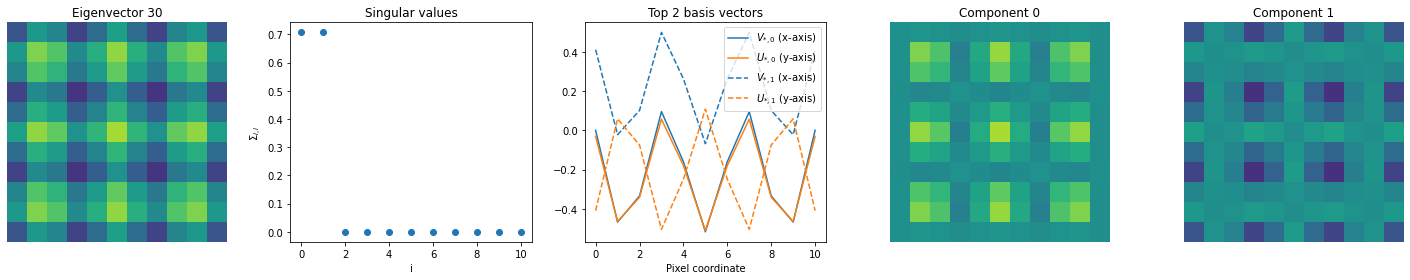

In [ ]:
adjacency = nx.to_numpy_array(nx.grid_graph((size, size)))
laplacian = np.diag(adjacency.sum(-1)) - adjacency
eigenvalues, eigenvectors = np.linalg.eigh(laplacian)

A = eigenvectors[:, 30].reshape(size, size)
U, S, V_T = np.linalg.svd(A)

_, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(1, 5, figsize=(5*4, 4))

ax0.imshow(A, vmin=-0.25, vmax=0.25)
ax0.axis("off")
ax0.set_title("Eigenvector 30")

ax1.scatter(np.arange(len(S)), S)
ax1.set_xlabel("i")
ax1.set_ylabel(r"$\Sigma_{i,i}$")
ax1.set_title("Singular values")

for idx, style in zip(range(2), ["-", "--"]):
    ax2.plot(V_T[idx, :], style, color="#1f77b4", label=f"$V_{{*,{idx}}}$ (x-axis)")
    ax2.plot(U[:, idx], style, color="#ff7f0e", label=f"$U_{{*,{idx}}}$ (y-axis)")
ax2.legend()
ax2.set_xlabel("Pixel coordinate")
ax2.set_title("Top 2 basis vectors")

ax3.imshow(S[0] * U[:, 0, np.newaxis] @ V_T[np.newaxis, 0, :], vmin=-0.25, vmax=0.25)
ax3.axis("off")
ax3.set_title("Component 0")

ax4.imshow(S[0] * U[:, 1, np.newaxis] @ V_T[np.newaxis, 1, :], vmin=-0.25, vmax=0.25)
ax4.axis("off")
ax4.set_title("Component 1")

plt.tight_layout()